# Convolutional Neural Networks (CNNs): Step-by-Step

This notebook introduces **Convolutional Neural Networks (CNNs)** in a clear and step-by-step manner.

#### Overview
- CNNs are a type of neural network that are particularly good at processing **images**.
- They are composed of **layers** that perform **operations** on the input data.
- CNNs use **filters/kernels** that slide over an image, looking for patterns (edges, corners, textures).
- Each filter is like a set of **pattern detectors**.
- By stacking layers of these detectors, CNNs can recognize **hierarchical features**: 
  - Edges → Shapes → Objects.

#### Why CNNs are good for vision tasks
- **Locality**: Focus on local pixel neighborhoods.
- **Translation invariance**: Features are detected anywhere in the image.
- **Parameter efficiency**: Small kernels are reused across the whole image.
- **Hierarchical feature learning**: From low-level edges to high-level objects.


## 2. Convolution (Theory)

Convolution is the operation at the heart of CNNs.

- A **kernel (filter)** slides over the image.
- At each position, compute a **dot product** between kernel values and the overlapping image patch.
- This produces a **feature map** highlighting where that pattern occurs.

Mathematically:
$$
(I * K)(i,j) = \sum_m \sum_n I(i+m, j+n) K(m,n)
$$

Example: An edge-detection kernel can highlight horizontal or vertical lines.


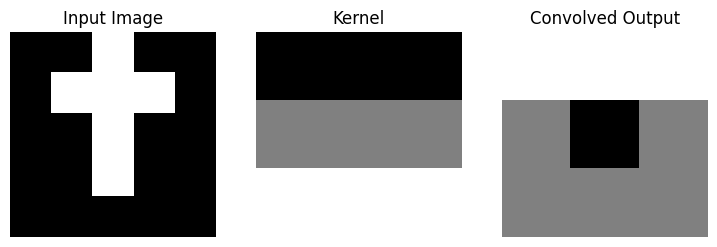

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Toy image (5x5 cross)
image = np.array([
    [0,0,1,0,0],
    [0,1,1,1,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
    [0,0,0,0,0]
])

# Horizontal edge detection kernel (3x3)
kernel = np.array([
    [-1,-1,-1],
    [ 0, 0, 0],
    [ 1, 1, 1]
])

def conv2d(img, k):
    h,w = img.shape
    kh,kw = k.shape
    out = np.zeros((h-kh+1, w-kw+1))
    for i in range(out.shape[0]):
        for j in range(out.shape[1]):
            out[i,j] = np.sum(img[i:i+kh, j:j+kw] * k)
    return out

conv_out = conv2d(image, kernel)

fig, axs = plt.subplots(1,3,figsize=(9,3))
axs[0].imshow(image, cmap='gray'); axs[0].set_title('Input Image')
axs[1].imshow(kernel, cmap='gray'); axs[1].set_title('Kernel')
axs[2].imshow(conv_out, cmap='gray'); axs[2].set_title('Convolved Output')
for ax in axs: ax.axis('off')
plt.show()

## 3. Pooling (Theory)

Pooling reduces the size of feature maps while keeping important information.

- **Max pooling**: keeps the strongest activation in a region.
- **Average pooling**: takes the average of a region.

Benefits:
- Reduces computation.
- Provides **translation invariance** (feature position changes slightly but detection remains).


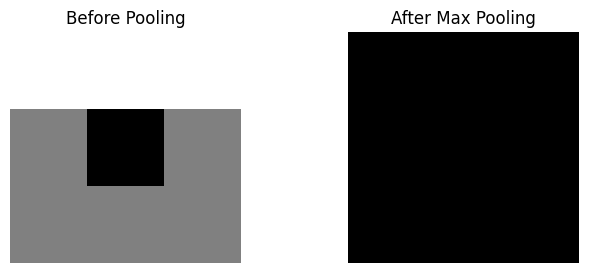

In [28]:
def max_pool(img, size=2):
    h, w = img.shape
    out_h, out_w = h // size, w // size  # floor division
    out = np.zeros((out_h, out_w))
    for i in range(out_h):
        for j in range(out_w):
            out[i, j] = np.max(img[i*size:(i+1)*size, j*size:(j+1)*size])
    return out


# Apply pooling to convolution output
pooled = max_pool(conv_out, 2)

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].imshow(conv_out, cmap='gray'); axs[0].set_title('Before Pooling')
axs[1].imshow(pooled, cmap='gray'); axs[1].set_title('After Max Pooling')
for ax in axs: ax.axis('off')
plt.show()

## 4. Activation Function (ReLU)

Neural networks need **non-linear activation functions**. Without them, stacking layers would still be equivalent to a single linear transformation.

The most common activation in CNNs is **ReLU (Rectified Linear Unit):**
$$ f(x) = \max(0, x) $$

Why ReLU?
- Simple and efficient.
- Helps avoid vanishing gradients (compared to sigmoid/tanh).
- Encourages sparse activations (many zeros).


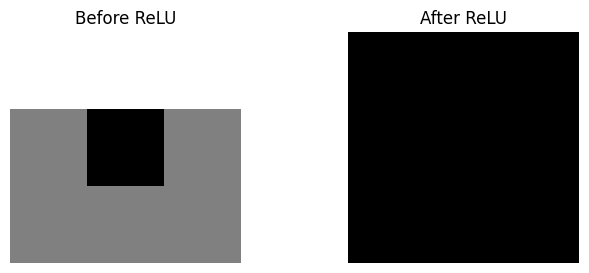

In [29]:
def relu(x):
    return np.maximum(0, x)

# Apply ReLU to convolution output
relu_out = relu(conv_out)

fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].imshow(conv_out, cmap='gray'); axs[0].set_title('Before ReLU')
axs[1].imshow(relu_out, cmap='gray'); axs[1].set_title('After ReLU')
for ax in axs: ax.axis('off')
plt.show()

## 5. Stacking Layers & Visualizations

CNNs become powerful when we **stack multiple layers**:
- First layer detects simple patterns (edges).
- Next layers combine them into textures, corners, shapes.
- Deeper layers recognize complex objects.

This hierarchy of features is why CNNs work so well for vision.


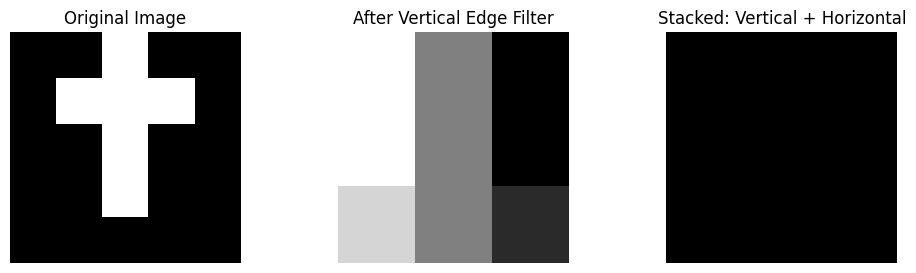

In [30]:
# Define two kernels: vertical and horizontal edges
kernel_vert = np.array([
    [-1,0,1],
    [-1,0,1],
    [-1,0,1]
])

kernel_horiz = np.array([
    [-1,-1,-1],
    [ 0, 0, 0],
    [ 1, 1, 1]
])

# Apply first convolution (vertical edges)
out1 = conv2d(image, kernel_vert)
# Apply second convolution (horizontal edges) on the result
out2 = conv2d(out1, kernel_horiz)

fig, axs = plt.subplots(1,3,figsize=(12,3))
axs[0].imshow(image, cmap='gray'); axs[0].set_title('Original Image')
axs[1].imshow(out1, cmap='gray'); axs[1].set_title('After Vertical Edge Filter')
axs[2].imshow(out2, cmap='gray'); axs[2].set_title('Stacked: Vertical + Horizontal')
for ax in axs: ax.axis('off')
plt.show()

## 6. Fully-Connected Layers (FC)

After several convolution + pooling + activation layers, we obtain **feature maps**.

To make final predictions (e.g. classification), we flatten these feature maps into a vector and pass them into one or more **fully-connected layers**:

$$ z = W x + b, \quad a = f(z) $$

- Each neuron in FC layers connects to **all inputs**.
- Final FC layer outputs class scores (before softmax).


In [31]:
# Example: Flatten pooled feature map into FC layer
flat = pooled.flatten()
print("Flattened vector:", flat)

# Simple FC layer (weights + bias)
W_fc = np.random.randn(3, flat.shape[0]) * 0.1  # 3 output classes
b_fc = np.zeros((3,))

fc_out = np.dot(W_fc, flat) + b_fc
print("FC layer output (class scores):", fc_out)

Flattened vector: [0.]
FC layer output (class scores): [0. 0. 0.]


## 7. Backpropagation Math (1D Example)

To train a CNN, we need to compute **gradients** of the loss with respect to weights.

This is done using **backpropagation**, which is just repeated use of the **chain rule**:
$$
\frac{dL}{dw} = \frac{dL}{da} \cdot \frac{da}{dz} \cdot \frac{dz}{dw}
$$

### Example: 1D Convolution
- Input: $x = [x_1, x_2, x_3]$
- Kernel: $w = [w_1, w_2]$
- Output: $y_1 = w_1 x_1 + w_2 x_2$, $y_2 = w_1 x_2 + w_2 x_3$

Loss: $L = (y_1 - t_1)^2 + (y_2 - t_2)^2$

Gradients:
$$
\frac{\partial L}{\partial w_1} = 2(y_1 - t_1)x_1 + 2(y_2 - t_2)x_2
$$
$$
\frac{\partial L}{\partial w_2} = 2(y_1 - t_1)x_2 + 2(y_2 - t_2)x_3
$$

Thus, weight updates depend on the input values that contributed to each output.


In [32]:
# Numerical example for 1D convolution backprop
x = np.array([1.0, 2.0, 3.0])
w = np.array([0.5, -0.4])
t = np.array([1.0, 0.0])  # targets

# Forward
y1 = w[0]*x[0] + w[1]*x[1]
y2 = w[0]*x[1] + w[1]*x[2]
y = np.array([y1, y2])
loss = np.sum((y - t)**2)

# Backward (manual gradients)
dL_dw1 = 2*(y1 - t[0])*x[0] + 2*(y2 - t[1])*x[1]
dL_dw2 = 2*(y1 - t[0])*x[1] + 2*(y2 - t[1])*x[2]

print("y:", y)
print("Loss:", loss)
print("dL/dw1:", dL_dw1)
print("dL/dw2:", dL_dw2)

y: [-0.3 -0.2]
Loss: 1.7300000000000002
dL/dw1: -3.400000000000001
dL/dw2: -6.400000000000001


## 8. Implementation: Simple CNN Training Loop (PyTorch)

Now that we understand the building blocks (convolution, pooling, activation, FC, backprop),
let’s train a simple CNN on the **MNIST dataset** using PyTorch.

Architecture:
- Conv2d → ReLU → MaxPool2d
- Flatten → Linear → ReLU → Linear (output)


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Conv2d(1, 8, 3, padding=1)  # 1 input channel, 8 filters
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(8*14*14, 64)
        self.fc2 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = x.view(-1, 8*14*14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# Model, loss, optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop (1 epoch for demo)
for epoch in range(1):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.0990


Epoch 1/5, Train Loss: 0.1140, Train Acc: 96.67%, Test Loss: 0.0953, Test Acc: 97.07%
Epoch 2/5, Train Loss: 0.0793, Train Acc: 97.62%, Test Loss: 0.0658, Test Acc: 97.81%
Epoch 3/5, Train Loss: 0.0584, Train Acc: 98.25%, Test Loss: 0.0601, Test Acc: 97.95%
Epoch 4/5, Train Loss: 0.0470, Train Acc: 98.56%, Test Loss: 0.0529, Test Acc: 98.19%
Epoch 5/5, Train Loss: 0.0399, Train Acc: 98.75%, Test Loss: 0.0538, Test Acc: 98.22%


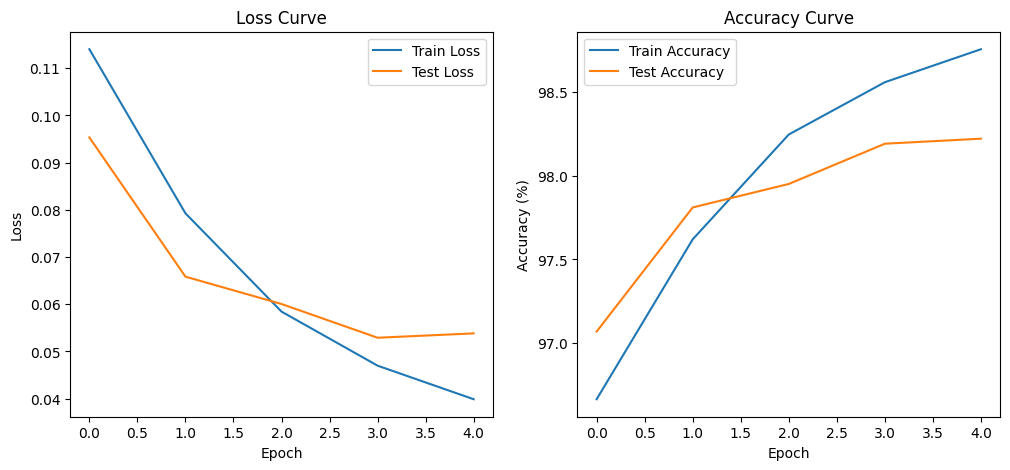

In [34]:
import matplotlib.pyplot as plt

# Training setup
num_epochs = 5
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Test data loader
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    # Training stats
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct, total, test_loss_val = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    test_loss = test_loss_val / len(test_loader)
    test_acc = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Plot learning curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()


## 9. Summary & Exercises

### Summary
- **Convolution**: detects local patterns using filters.
- **Pooling**: reduces feature map size and provides translation invariance.
- **ReLU Activation**: introduces non-linearity and sparsity.
- **Stacking**: deeper layers learn hierarchical features.
- **Fully Connected Layers**: map learned features to outputs (e.g. class scores).
- **Backpropagation**: efficient computation of gradients using chain rule.
- **Training Loop (PyTorch)**: demonstrated CNN training on MNIST.

### Exercises
1. **Change kernels**: Try edge detection, blur, sharpen filters.
2. **Pooling variations**: Compare Max Pooling vs Average Pooling.
3. **Activation functions**: Replace ReLU with Sigmoid or Tanh.
4. **Deeper networks**: Add more Conv2d + Pool layers in the PyTorch model.
5. **Learning rate experiments**: Try different optimizers or learning rates.
6. **Custom dataset**: Replace MNIST with CIFAR-10 or your own images.

By experimenting with these, you'll develop a deeper intuition for CNNs.
